# Machine Learning for Thyroid Cancer Diagnosis.
##  Part 3: SVMs
**The project was done with Rajiv Krishnakumar and Raghu Mahajan.**

The essential goal was to predict thyroid cancer given gene expressions. A key hope is to definitively predict benign samples; this helps to avoid unnecessary surgeries, which often turn out to be much more problematic to a patient's health, than the thyroid cancer itself.


- The data used here is pre-normalized, to mean zero and standard deviation 1. 
- The essentials of the data set are 265 patients whose biopsies were inconclusive, each with 173 reported gene expression levels. 
- There were a further 102 patients with 'conclusive' biopsies - i.e. a human determination of benign vs. malignant, to give 367 total patients.

Here is an abstract from our final report:

*We investigate the use of high throughput gene expression data in the diagnosis of thyroid cancers. Using logistic regression and support vector machines (SVMs), we develop a classifier which gives similar performance (89% sensitivity and 80% specificity) to the currently best- known classifier, but uses significantly fewer features. We used two different techniques, principal components analysis and mutual information score, to select features. The results do not depend significantly on which method is used for feature selection.*

The breakdown of topics covered in each notebook is as follows:
1. Data visualization, including PCA and tSNE visualizations.
2. Logistic regression, with feature selection using different regularizers or different numbers of Principal components.
3. SVMs with and without box constraints, and also using different kernel functions.

In [1]:
#As usual import some modules and import the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import the data and look at it
X = pd.read_csv("data/normalized_data_265.csv", header =None)
y = pd.read_csv("data/outcome_265.csv", header = None)


X_full = pd.read_csv("data/normalized_data_367.csv", header =None)
y_full = pd.read_csv("data/outcome_367.csv", header = None)



#Now turn these into numpy arrays to avoid problems with pandas dataframes
X = X.as_matrix()
y = y.as_matrix().reshape(len(y))
X_full = X_full.as_matrix()
y_full = y_full.as_matrix().reshape(len(y_full))

## Support Vector Machine

Let us now fit an SVM decision boundary to the data. 

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn import svm


#First perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)



#Now run the SVM
classifier = svm.SVC()
classifier.fit(X_train, y_train)


print ""
print "-----Logistic Regression-----"
print ""
print "Training accuracy: ",classifier.score(X_train,y_train)
print "Test set accuracy: ",classifier.score(X_test,y_test)


-----Logistic Regression-----

Training accuracy:  0.915094339623
Test set accuracy:  0.849056603774


Looks promising/more realistic - let's breakdown into sensitivites and specificities on training and test set once again (definitions are contained in Part 2: Logistic Regression notebook)

In [3]:
from sklearn.metrics import confusion_matrix

y_pred_test = classifier.predict(X_test)
y_pred_full = classifier.predict(X)

confusion_test = confusion_matrix(y_test,y_pred_test)
confusion_full = confusion_matrix(y,y_pred_full)

print "Test Specificity =", confusion_test[0,0]/(1.0*(confusion_test[0,0] + confusion_test[0,1]))
print "Test Sensitivity =", confusion_test[1,1]/(1.0*(confusion_test[1,0] + confusion_test[1,1]))

print "Total Specificity =", confusion_full[0,0]/(1.0*(confusion_full[0,0] + confusion_full[0,1]))
print "Total Sensitivity =", confusion_full[1,1]/(1.0*(confusion_full[1,0] + confusion_full[1,1]))

Test Specificity = 0.975
Test Sensitivity = 0.461538461538
Total Specificity = 0.983333333333
Total Sensitivity = 0.729411764706


That's some pretty awful performance on the test set!



## Varying the Kernel

To get a feel for what the SVM does, let us visualize it's results by training on **only the top two principal components**, and plotting the resulting decision boundaries, for different Kernels.

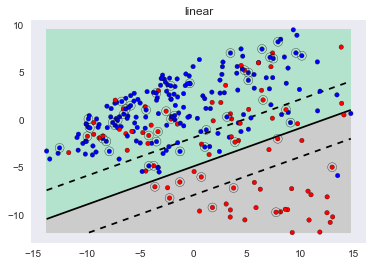

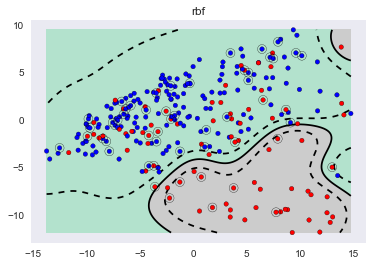

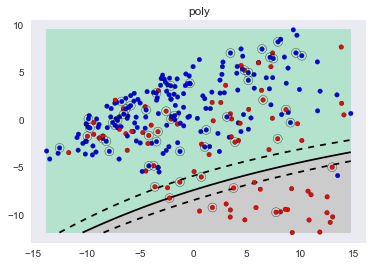

In [4]:
from sklearn import decomposition


#First perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)



#Create and run the PCA object
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X)
X_pca_train = pca.transform(X_train)[:,:2]
X_pca_test = pca.transform(X_test)[:,:2]


#Loop over different Kernels and plot results
for fig_num, kernel in enumerate(('linear', 'rbf', 'poly')):
    clf = svm.SVC(kernel=kernel, gamma=0.1)
    clf.fit(X_pca_train[:,:2], y_train)

    plt.figure(fig_num)
    plt.clf()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, zorder=10, cmap=plt.cm.bwr)

    # Circle out the test data
    plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1], s=80, facecolors='none', zorder=10)

    plt.axis('tight')
    x_min = X_pca[:, 0].min()
    x_max = X_pca[:, 0].max()
    y_min = X_pca[:, 1].min()
    y_max = X_pca[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Pastel2)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

## PCA + SVM pipeline
Let's once more repeat the approach of doing PCA on the bare data, and then logistic regression on top of this.

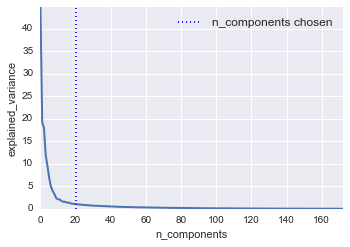

Best Paramters:  {'pca__n_components': 20, 'svm__C': 0.0021544346900318821}
Final accuracy:  0.894339622642
Total Specificity = 0.894444444444
Total Sensitivity = 0.894117647059


In [52]:
from sklearn import decomposition, svm
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

clf = svm.SVC(kernel = 'poly',class_weight={1:4})

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('svm', clf)])



###############################################################################
# Plot the PCA spectrum
pca.fit(X)

plt.figure(1, figsize=(6, 4))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance')

###############################################################################
# Prediction

n_components = [5,10,15,20,30,40]
Cs = np.logspace(-4, -2, 10)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                             svm__C = Cs), cv=10)
estimator.fit(X, y)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

print "Best Paramters: ", estimator.best_params_
print "Final accuracy: ",estimator.best_estimator_.score(X,y)


y_pred_full = estimator.best_estimator_.predict(X)
confusion_full = confusion_matrix(y,y_pred_full)

print "Total Specificity =", confusion_full[0,0]/(1.0*(confusion_full[0,0] + confusion_full[0,1]))
print "Total Sensitivity =", confusion_full[1,1]/(1.0*(confusion_full[1,0] + confusion_full[1,1]))

**These figures are slightly better than the best we obtained in our study!!**

***Can we trust this? - this has nominally used cross validation, so perhaps yes!?***

## Estimating the generalization error 
### Using pre-diagnosed patients as validation set

As another test: let us introduce a validation set, i.e. let us introduce the "pre-determined" thyroid cancers. We have not trained or cross validated on this data, so the performance of the classifier serves as a useful estimate of the generalization error.

In [57]:
X_valid = pd.read_csv("data/normalized_data_102.csv", header =None)
y_valid = pd.read_csv("data/outcome_102.csv", header = None)



y_pred_valid = estimator.best_estimator_.predict(X_valid)
confusion_valid = confusion_matrix(y_valid,y_pred_valid)
print confusion_valid
print "------Performance on Validation Set - 102 patients------"
print "Validation Specificity =", confusion_valid[0,0]/(1.0*(confusion_valid[0,0] + confusion_valid[0,1]))
print "Validation Sensitivity =", confusion_valid[1,1]/(1.0*(confusion_valid[1,0] + confusion_valid[1,1]))



y_pred_all = estimator.best_estimator_.predict(X_full)
confusion_all = confusion_matrix(y_full,y_pred_all)
print ""
print "------Performance on All data - 367 patients------"
print "Total Specificity =", confusion_all[0,0]/(1.0*(confusion_all[0,0] + confusion_all[0,1]))
print "Total Sensitivity =", confusion_all[1,1]/(1.0*(confusion_all[1,0] + confusion_all[1,1]))

[[44  0]
 [13 45]]
------Performance on Validation Set - 102 patients------
Validation Specificity = 1.0
Validation Sensitivity = 0.775862068966

------Performance on All data - 367 patients------
Total Specificity = 0.933035714286
Total Sensitivity = 0.881118881119


***Certainly seems like we are doing well - if not spectacularly so?***